# Cluster analyses of the image embeddings

In this notebook we aim at analyzing the structure of the inferred image embeddings and associated gene perturbation embeddings and compare it to the structure observed in related data sets like the morphological profiles of Rohban et al. (2017) and related gene signatures from the CMap data set.

---

## 0. Environmental setup

First, we setup the environment by loading required packages.

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from cmapPy.pandasGEXpress.parse import parse
from scipy.spatial.distance import squareform, pdist
import matplotlib as mpl
import os

import sys
from yellowbrick.cluster import KElbowVisualizer

sys.path.append("../../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from src.utils.notebooks.images.embedding import *
from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *

mpl.rcParams["figure.dpi"] = 600

In [2]:
def run_cc_test(cluster_sol1, cluster_sol2, b=1000, score="mi", random_state=1234):
    np.random.seed(random_state)
    cc_score = compute_cc_score(cluster_sol1, cluster_sol2, score=score)
    perm_cc_scores = []
    for i in tqdm(range(b)):
        cluster_sol1_perm = np.random.permutation(cluster_sol1)
        cluster_sol2_perm = np.random.permutation(cluster_sol2)
        perm_cc_score = compute_cc_score(
            cluster_sol1_perm, cluster_sol2_perm, score=score
        )
        perm_cc_scores.append(perm_cc_score)
    perm_cc_scores = np.array(perm_cc_scores)
    return {
        "cc_score": cc_score,
        "perm_cc_scores": perm_cc_scores,
        "pval": np.mean(perm_cc_scores >= (cc_score - 1e-8), axis=0),
    }

---

## 1. Read in data

Next, we read in all the required data sets. This first consists of the image embeddings derived from the chromatin image inputs. For the analysis, we randomly choose the embeddings obtained from the first fold of the applied 4-fold cross-validation approach when inferring the image embeddings. To not bias our analyses we will use the test set embeddings obtained from the respecitvely trained convolutional neureal network. Note that this is selection is consistent with the previous analysis e.g. when visualizing the inferred image embeddings.

In [3]:
physical_space_embs = pd.read_hdf(
    "../../../../data/experiments/rohban/images/embeddings/four_fold_cv/fold_0/test_latents.h5"
)

label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "EMPTY": 14,
    "ERG": 15,
    "FGFR3": 16,
    "FOXO1": 17,
    "GLI1": 18,
    "HRAS": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MOS": 27,
    "MYD88": 28,
    "PIK3R2": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SMAD4": 35,
    "SMO": 36,
    "SRC": 37,
    "SREBF1": 38,
    "TRAF2": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
physical_space_embs.loc[:, "labels"] = np.array(
    physical_space_embs.labels.map(label_dict)
)
mean_physical_space_embs = physical_space_embs.groupby("labels").mean()

oe_targets = set(mean_physical_space_embs.index) - {"EMPTY"}

In [4]:
def load_and_preprocess_morphological_profiles(profile_file, md_file, save=True):
    morph_profiles = pd.read_csv(profile_file)
    image_metadata = pd.read_csv(md_file, index_col=0)
    image_numbers = morph_profiles.loc[:, "ImageNumber"]
    labels = image_numbers.map(
    dict(
        zip(
            list(image_metadata.loc[:, "ImageNumber"]),
            list(image_metadata.loc[:, "Image_Metadata_GeneSymbol"]),
        )
    )
)
    drop_columns = ["Nuclei_Number_Object_Number"]
    for col in morph_profiles.columns:
        if "ERSyto" in col:
            drop_columns.append(col)
        elif "Mito" in col:
            drop_columns.append(col)
        elif "PhGolgi" in col:
            drop_columns.append(col)
    
    morph_profiles = morph_profiles.loc[morph_profiles.ImageNumber.isin(image_metadata.ImageNumber.unique())]
    morph_profiles = morph_profiles.drop(drop_columns, axis=1)
    morph_profiles["labels"] = labels
    # Drop invariant columns and remove NaN rows
    morph_profiles = morph_profiles.loc[
    :, (morph_profiles != morph_profiles.iloc[0]).any()
]
    morph_profiles = morph_profiles.dropna()
    if save:
        os.makedirs("../../../../data/resources/images/rohban/profiles", exist_ok=True)
        morph_profiles.to_csv("../../../../data/resources/images/rohban/profiles/nuclei_profiles_hoechst_cleaned.csv")
    return morph_profiles, image_metadata


Note that we identify the gene perturbation embeddings as the mean of the image embeddings corresponding to a given gene perturbation setting.

Next, we load the preprocessed CMAP data set.

In [5]:
mean_cmap_sigs = pd.read_csv(
    "../../../../data/experiments/rohban/gex/cmap/mean_l5_signatures_tmp.csv",
    index_col=0,
)

Finally, we load the morphological profiles that were derived for the same data set by Rohban et al. (2017). Note that we have already removed all features that do not correspond to the data available from the Hoechst stained channels as the physical space embeddings are also solely use information obtained from the Hoechst stained images.

In [6]:
# _, image_metadata = load_and_preprocess_morphological_profiles(profile_file="../../../../data/resources/images/rohban/metadata/nuclei_morph_profiles.csv", md_file = "../../../../data/experiments/rohban/images/preprocessing/full_pipeline/filtered_image_metadata.csv")

In [7]:
morph_profiles = pd.read_csv(
    "../../../../data/resources/images/rohban/profiles/nuclei_profiles_hoechst_cleaned.csv",
    index_col=0,
)
mean_morph_profiles = (
    morph_profiles.groupby("labels").mean().drop(columns=["ImageNumber"])
)

To uniquely represent each target by a corresponding gene signature, morphological profile or image embeddings we will consider the means of all related embeddings.


The morphological profiles are already partly preprocessed as all features corresponding to the other channels had initially been removed. Nonetheless, they still include a number of positional features that we want to exclude for the analysis as e.g. the location of a nuclei or its neighbors is not informative to characterize its nuclear phenotype.

In [8]:
mean_morph_profiles = mean_morph_profiles.drop(
    mean_morph_profiles.filter(regex="_X").columns, axis=1
)
mean_morph_profiles = mean_morph_profiles.drop(
    mean_morph_profiles.filter(regex="_Y").columns, axis=1
)

Finally, we scale the moprhological embeddings to acccount for the vastly different scales of the individual features that are not related to their importance.

In [9]:
mean_morph_profiles = pd.DataFrame(
    StandardScaler().fit_transform(mean_morph_profiles),
    index=mean_morph_profiles.index,
    columns=mean_morph_profiles.columns,
)

---

## 3. Clustering of the different signatures and embeddings

Having preprocessed the individual descriptions of the response of cells to the overexpression conditions, we will now assess the structure of the correspondly spanned latent spaces. To this end, we will hierarchically cluster all embeddings using euclidean distances for the physical space embeddings and morphological profiles and cosine distances for the CMAP gene signatures. Complete linkage is chosen for all clusterings to obtain compact clusters and the optimal number of clusters is determined by looking at the Silhouette and Calisnki-Harabasz score for cluster cutoffs in [2,15].

In [10]:
oe_targets = oe_targets.intersection(list(mean_morph_profiles.index)).intersection(
    mean_cmap_sigs.index
)
len(oe_targets)

41

### 3.a. Clustering of the gene perturbation embeddings.

We start with the clustering of the physical space.

<ipython-input-11-e4c5a16b569c>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_physical_space_embs.loc[oe_targets])


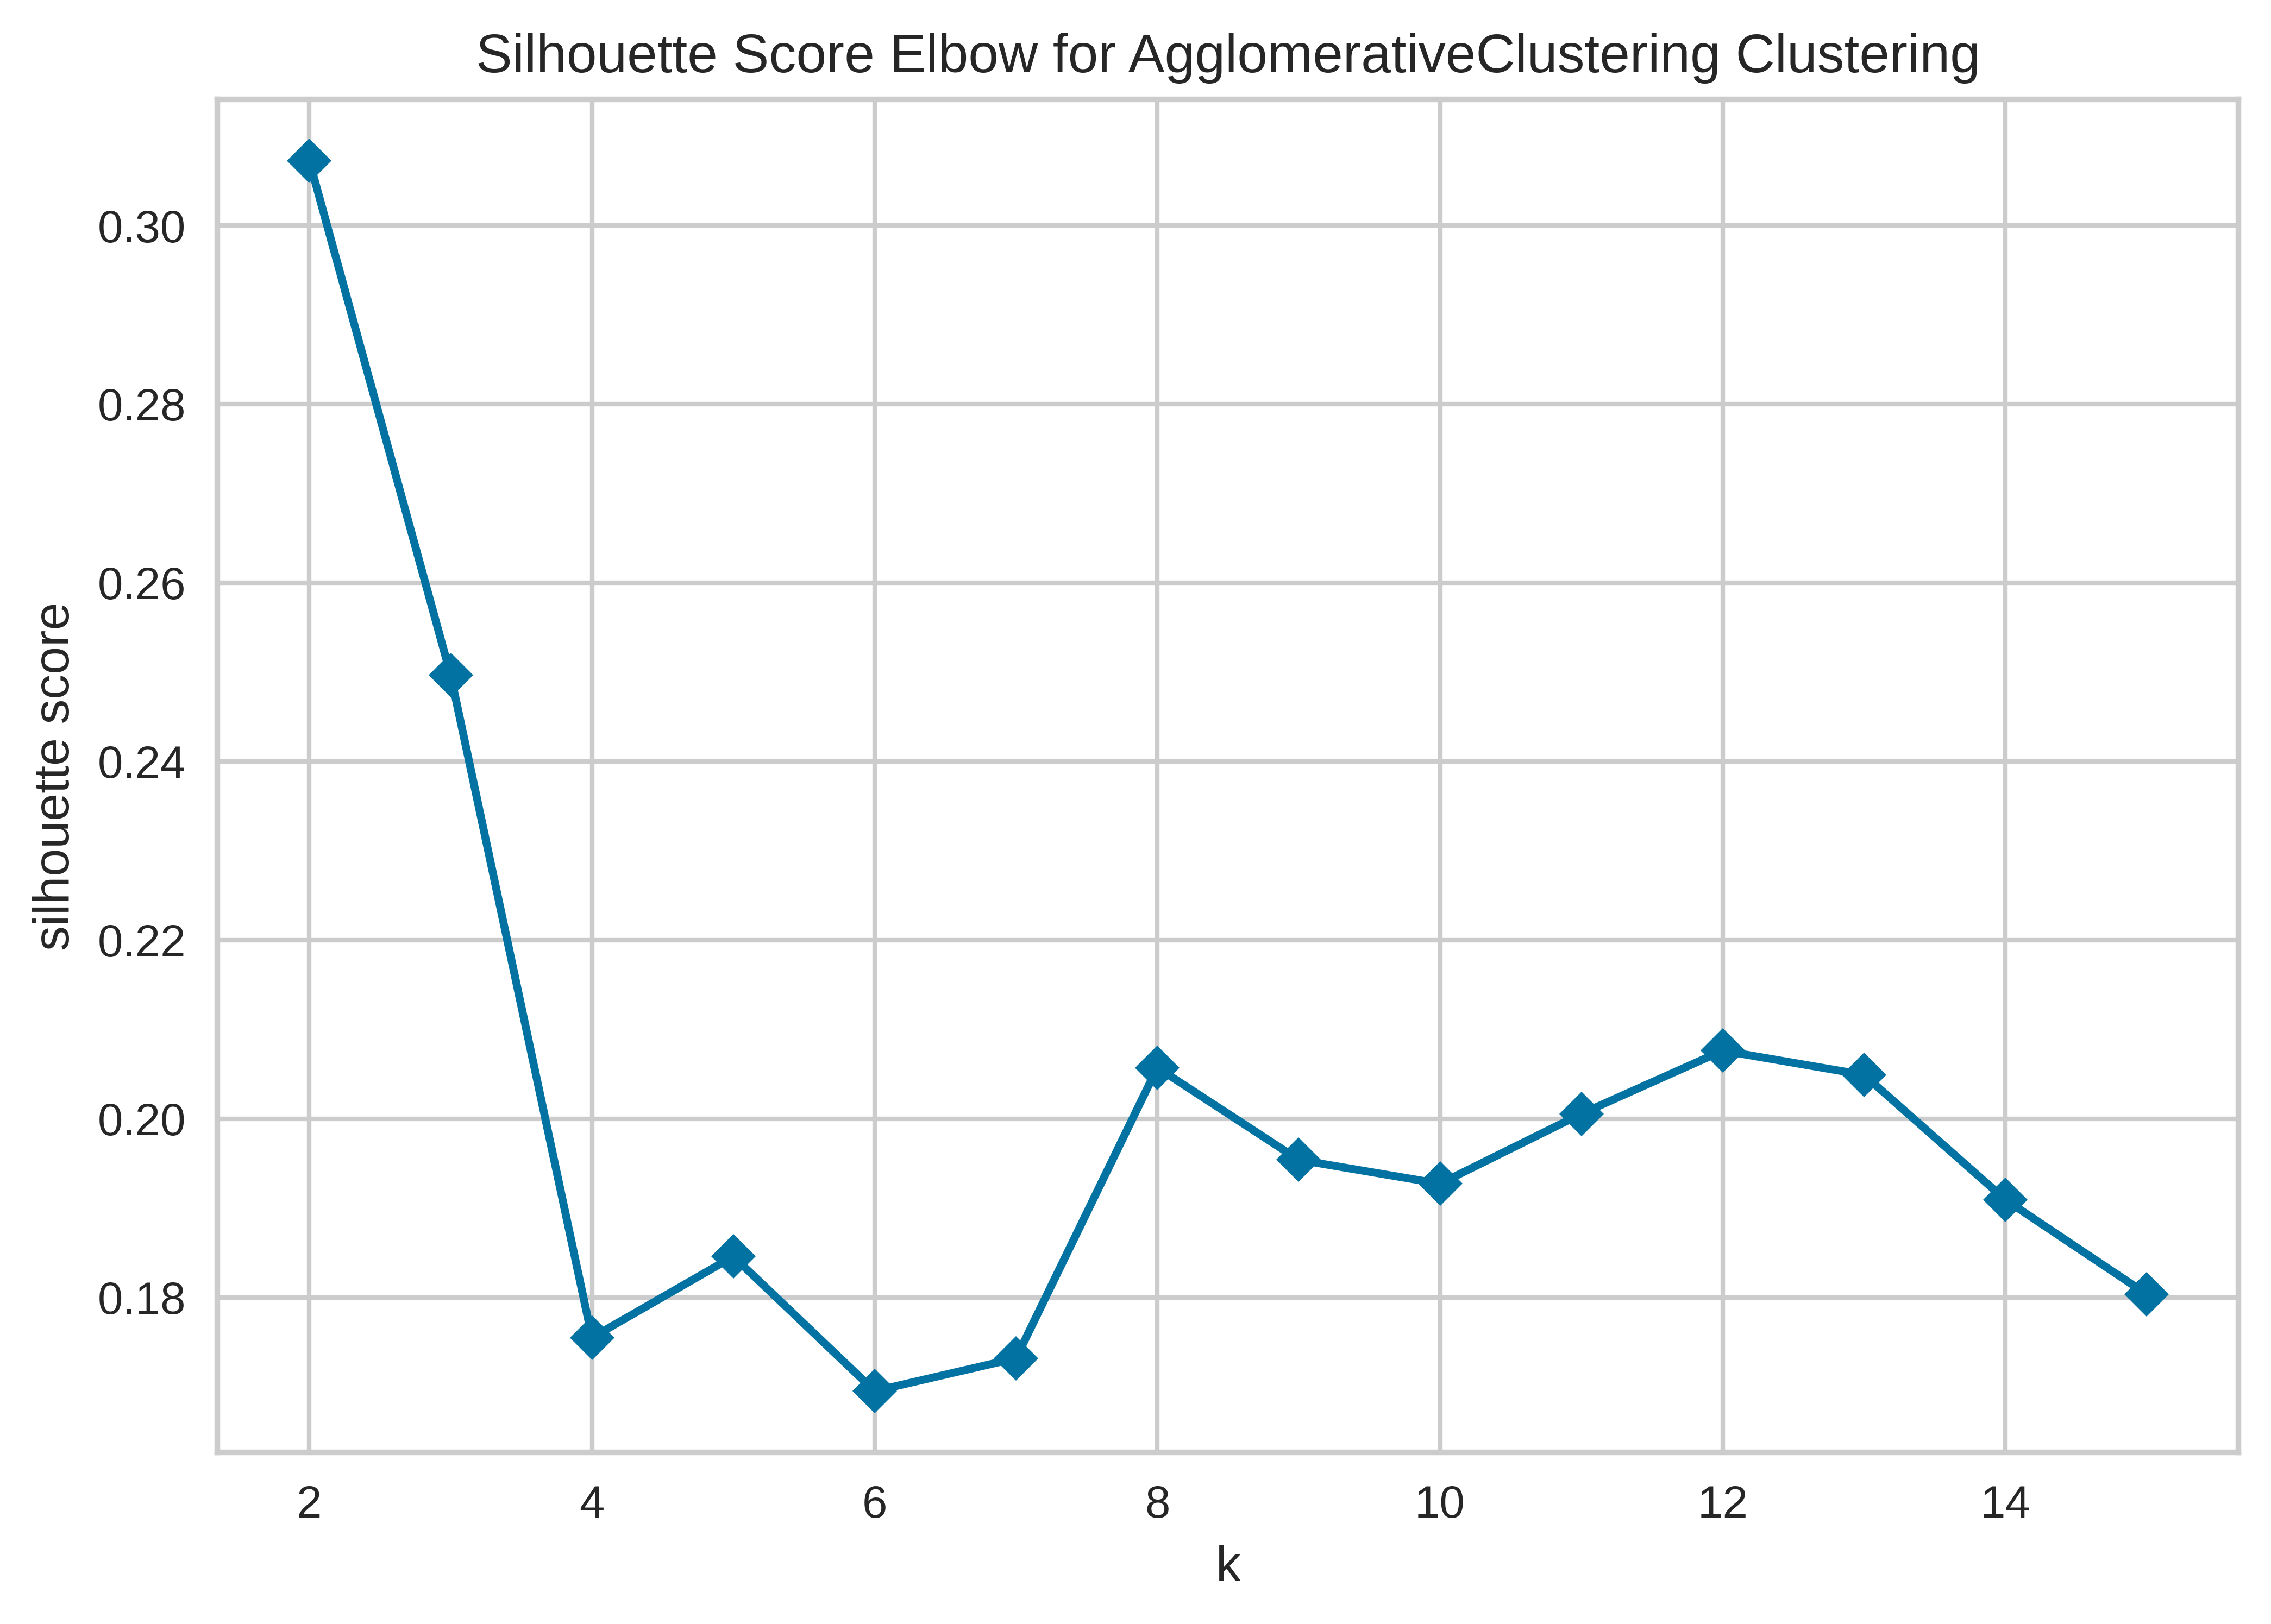

<ipython-input-11-e4c5a16b569c>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_physical_space_embs.loc[oe_targets])


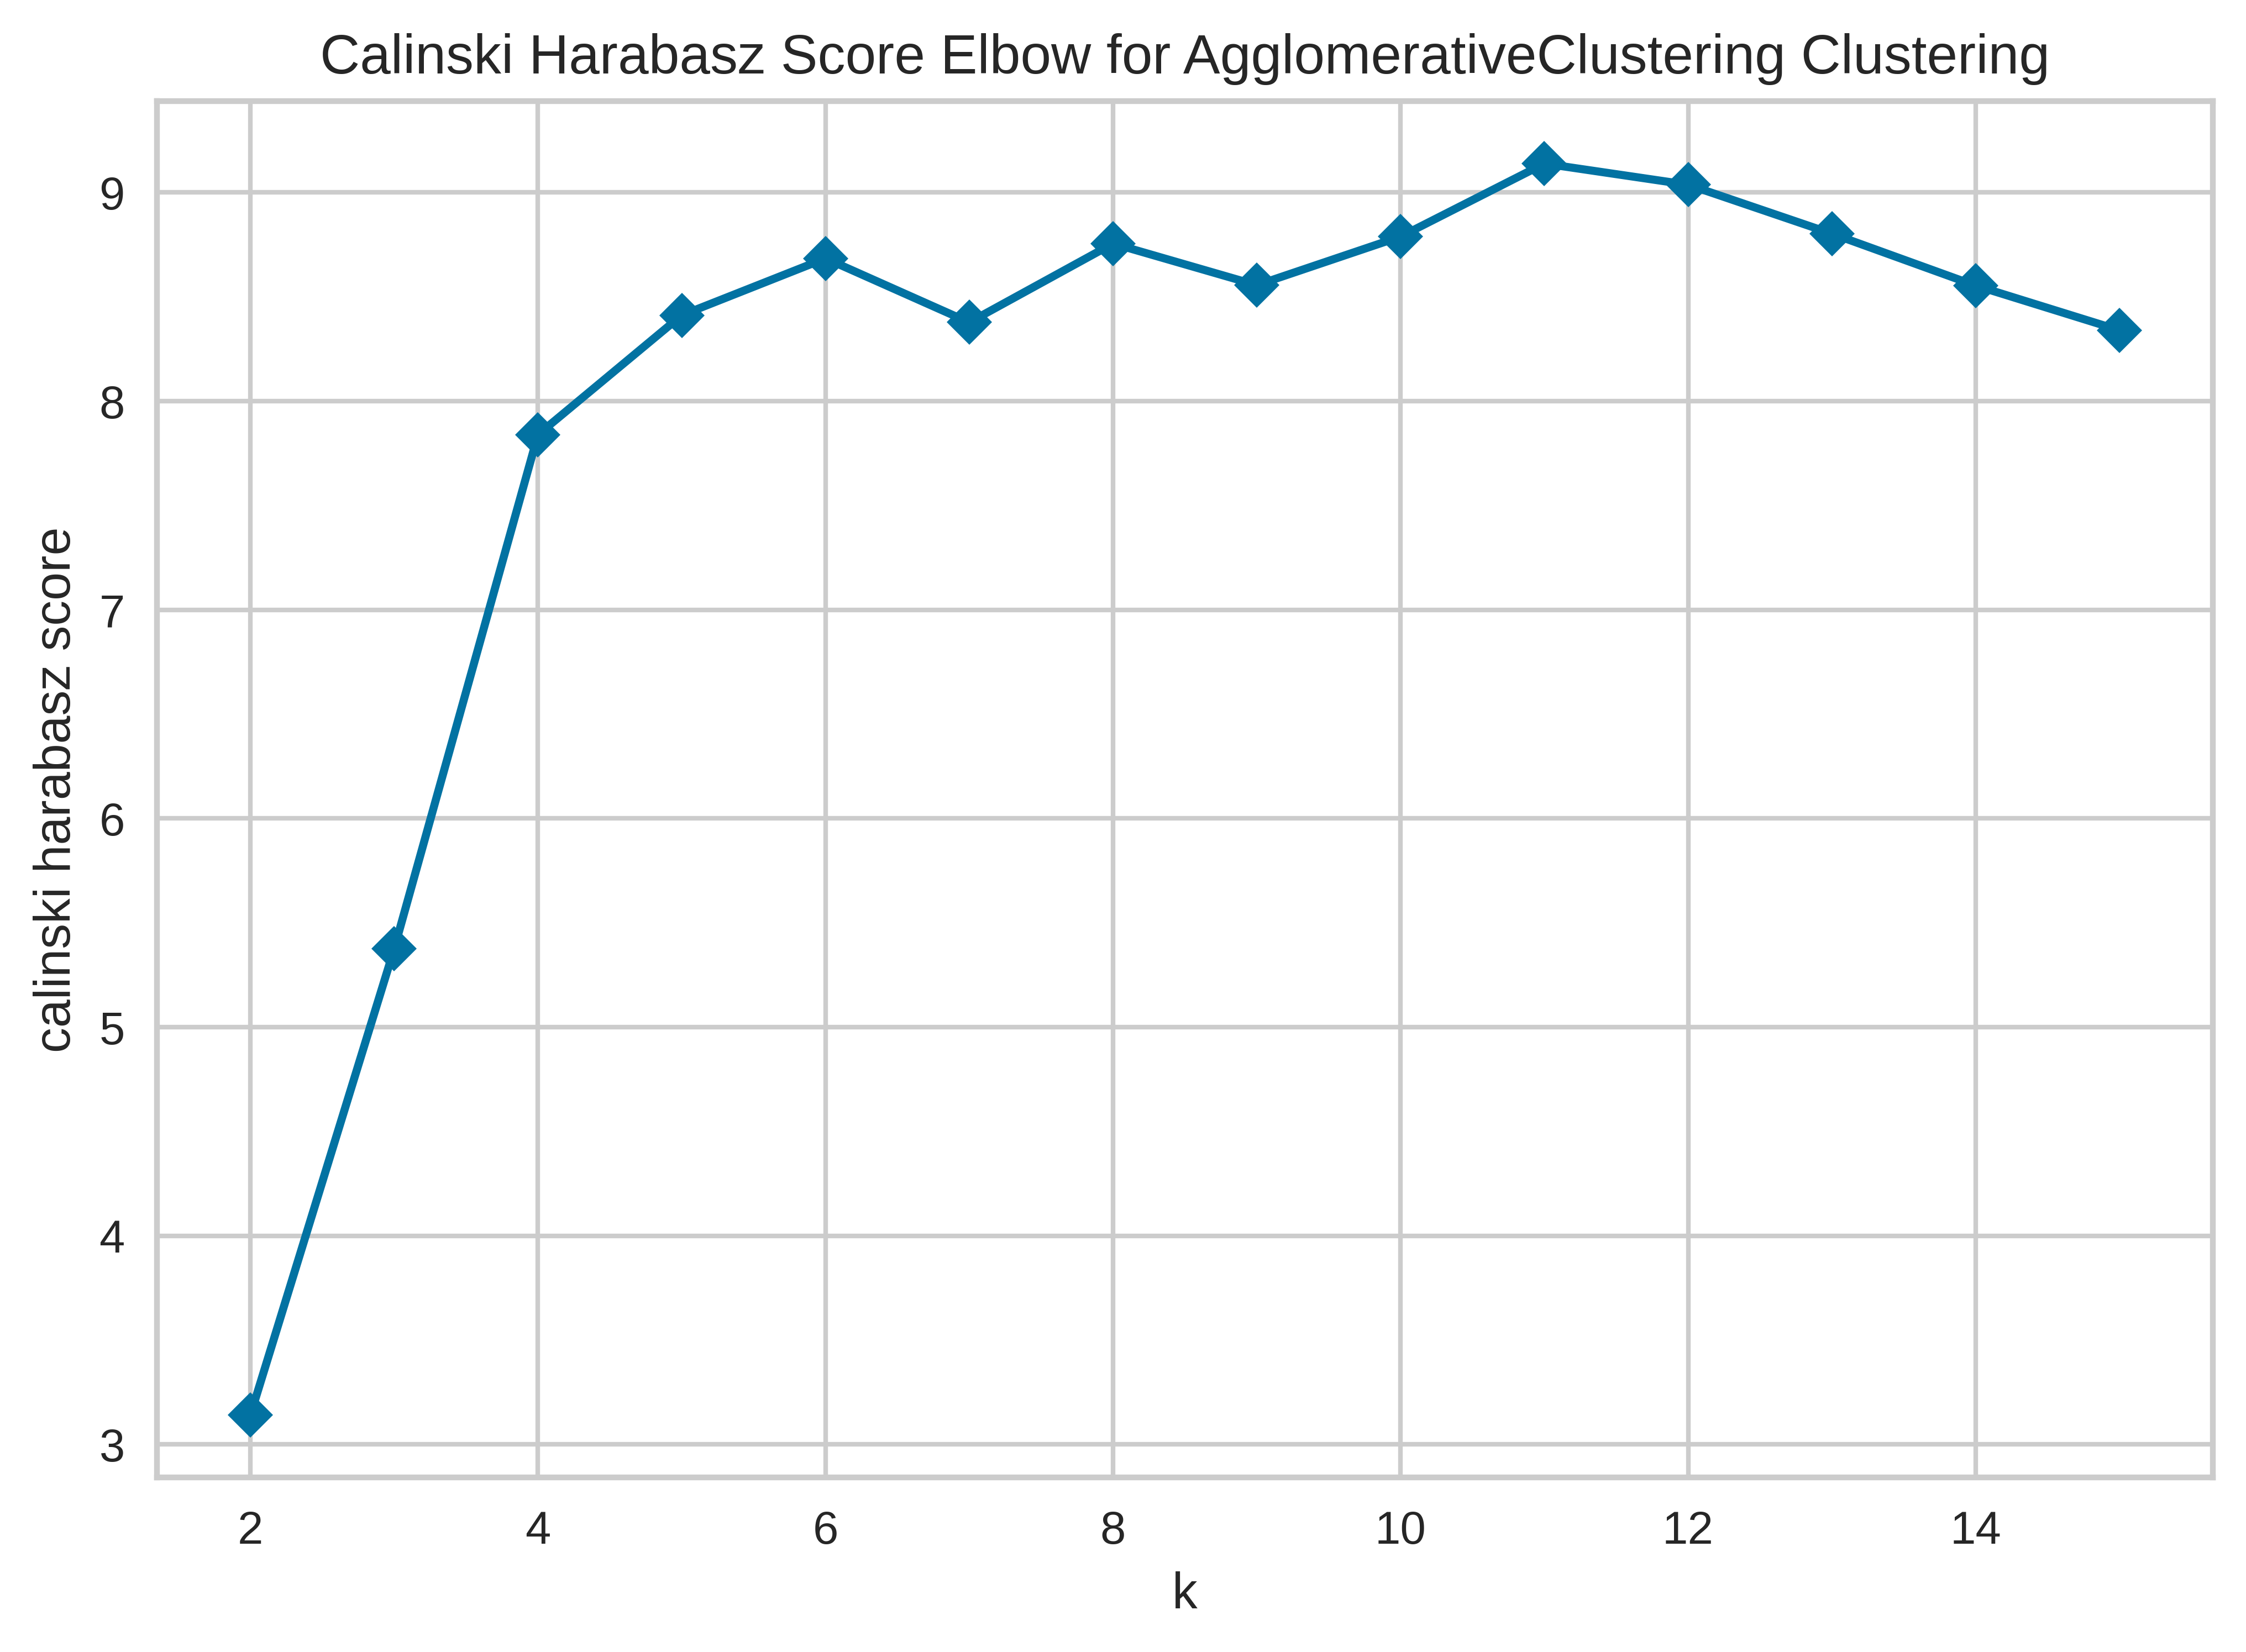

In [11]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_physical_space_embs.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_physical_space_embs.loc[oe_targets])
ax = visualizer.show()

The above plots indicate that the data is best divided into 11 clusters as this maximizes the Calinski-Harabsz score and reaches a local optima of the Silhouette score. Thus, we focus at the solution consisting of 11 clusters.

In [12]:
model = AgglomerativeClustering(n_clusters=11, affinity="euclidean", linkage="complete")
phy_space_cluster_labels = model.fit_predict(mean_physical_space_embs.loc[oe_targets])
phy_space_clusters = pd.DataFrame(
    phy_space_cluster_labels,
    index=mean_physical_space_embs.loc[oe_targets].index,
    columns=["cluster"],
)
lut = dict(
    zip(
        list(np.unique(phy_space_cluster_labels)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "tab:purple",
            "tab:pink",
            "tab:olive",
            "olivedrab",
            "tab:brown",
        ],
    )
)
phy_space_colors = pd.Series(
    phy_space_cluster_labels,
    index=mean_physical_space_embs.loc[oe_targets].index,
).map(lut)

<ipython-input-12-7f44e5331f99>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  phy_space_cluster_labels = model.fit_predict(mean_physical_space_embs.loc[oe_targets])
<ipython-input-12-7f44e5331f99>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_physical_space_embs.loc[oe_targets].index,
<ipython-input-12-7f44e5331f99>:28: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_physical_space_embs.loc[oe_targets].index,


In [13]:
mean_phy_space_embs_dist = pd.DataFrame(
    squareform(pdist(mean_physical_space_embs.loc[oe_targets])),
    index=mean_physical_space_embs.loc[oe_targets].index,
    columns=mean_physical_space_embs.loc[oe_targets].index,
)

linkage = hc.linkage(squareform(mean_phy_space_embs_dist), method="complete")

ax = sns.clustermap(
    mean_phy_space_embs_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="gray",
    row_colors=np.array(phy_space_colors.loc[mean_phy_space_embs_dist.index]),
    col_colors=np.array(phy_space_colors.loc[mean_phy_space_embs_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
    cbar_kws={"shrink": 3, "label": "Euclidean\ndistance"},
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)

ax.ax_cbar.set_ylabel("Euclidean\ndistance", size=15, weight="bold")
ax.ax_cbar.yaxis.set_label_position("left")
plt.show()

<ipython-input-13-888b765b4761>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  squareform(pdist(mean_physical_space_embs.loc[oe_targets])),
<ipython-input-13-888b765b4761>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_physical_space_embs.loc[oe_targets].index,
<ipython-input-13-888b765b4761>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  columns=mean_physical_space_embs.loc[oe_targets].index,


In [14]:
print(list(mean_phy_space_embs_dist))

['FGFR3', 'MAPK7', 'PRKCE', 'RHOA', 'MAP3K2', 'MAP3K5', 'ELK1', 'GLI1', 'CDC42', 'CREB1', 'CASP8', 'CDKN1A', 'SMO', 'WWTR1', 'SREBF1', 'CXXC4', 'BRAF', 'PIK3R2', 'IRAK4', 'FOXO1', 'HRAS', 'TSC2', 'JUN', 'ATF4', 'RAF1', 'RELB', 'BCL2L11', 'CEBPA', 'E2F1', 'ERG', 'PRKACA', 'MAP2K3', 'TRAF2', 'SRC', 'MOS', 'MYD88', 'AKT1S1', 'DIABLO', 'MAP3K9', 'BAX', 'SMAD4']


In [15]:
cluster_dict = {}
for cluster_label in np.unique(phy_space_clusters.cluster):
    cluster_dict[cluster_label] = list(
        np.array(list(phy_space_clusters.index))[
            phy_space_clusters.cluster == cluster_label
        ]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, v))
    print("")

Cluster 0: ['RHOA', 'SMO', 'WWTR1', 'SREBF1', 'FOXO1', 'MYD88', 'DIABLO']

Cluster 1: ['FGFR3', 'PRKCE', 'PIK3R2', 'TRAF2', 'SRC', 'MOS', 'AKT1S1']

Cluster 2: ['MAP3K2', 'CDC42', 'BRAF', 'RAF1', 'MAP3K9']

Cluster 3: ['CASP8', 'BCL2L11']

Cluster 4: ['MAPK7', 'MAP3K5', 'RELB', 'MAP2K3']

Cluster 5: ['CREB1', 'IRAK4', 'TSC2', 'ATF4', 'BAX', 'SMAD4']

Cluster 6: ['JUN', 'CEBPA', 'ERG']

Cluster 7: ['CDKN1A']

Cluster 8: ['HRAS']

Cluster 9: ['ELK1', 'E2F1']

Cluster 10: ['GLI1', 'CXXC4', 'PRKACA']



The output above shows the 11 prominent gene clusters that we identified by clustering the physical space embeddings. A gene ontology analysis indicates the biological meaningfulness of the identified clusters.

---

### 2.c. Clustering of the functional (CMAP signature) space

Next, we cluster the CMAP signatures again using hierarchical clustering with complete linkage but using cosine similarity to identify cluster of overexpression settings that lead to changes of the same directionality in the gene expression space. To visualize the correspondence of the clustering of the functional and physical space, the physical space clusters are transfered by color-coding the corresponding genes in the cluster map below.

In [16]:
mean_cmap_sigs_dist = pd.DataFrame(
    squareform(pdist(mean_cmap_sigs.loc[oe_targets], "cosine")),
    index=mean_cmap_sigs.loc[oe_targets].index,
    columns=mean_cmap_sigs.loc[oe_targets].index,
)

linkage = hc.linkage(squareform(mean_cmap_sigs_dist), method="complete")

ax = sns.clustermap(
    mean_cmap_sigs_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="inferno",
    row_colors=np.array(phy_space_colors.loc[mean_cmap_sigs_dist.index]),
    col_colors=np.array(phy_space_colors.loc[mean_cmap_sigs_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_cbar.set_ylabel("Cosine\ndistance", size=15, weight="bold")
ax.ax_cbar.yaxis.set_label_position("left")
# plt.title(
#     "Euclidean distance map of the CMAP signatures with physical space cluster identities\n(Significant co-clustering MI-based permutation test: p-value < 1e-5)",
#     loc="center",
# )
plt.show()

<ipython-input-16-f4d34ae8d42a>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  squareform(pdist(mean_cmap_sigs.loc[oe_targets], "cosine")),
<ipython-input-16-f4d34ae8d42a>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_cmap_sigs.loc[oe_targets].index,
<ipython-input-16-f4d34ae8d42a>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  columns=mean_cmap_sigs.loc[oe_targets].index,


Despite the differences in the overall structure we see a few gene clusters identified in the gene perturbation embeddings to be preserved. To assess the statistical significance of the co-cluster, we first determine a single cluster solution by again assessing the Calinski-Harabasz and Silhouette score for varying cluster cutoffs.

<ipython-input-17-fccb64e3fcde>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_cmap_sigs.loc[oe_targets])


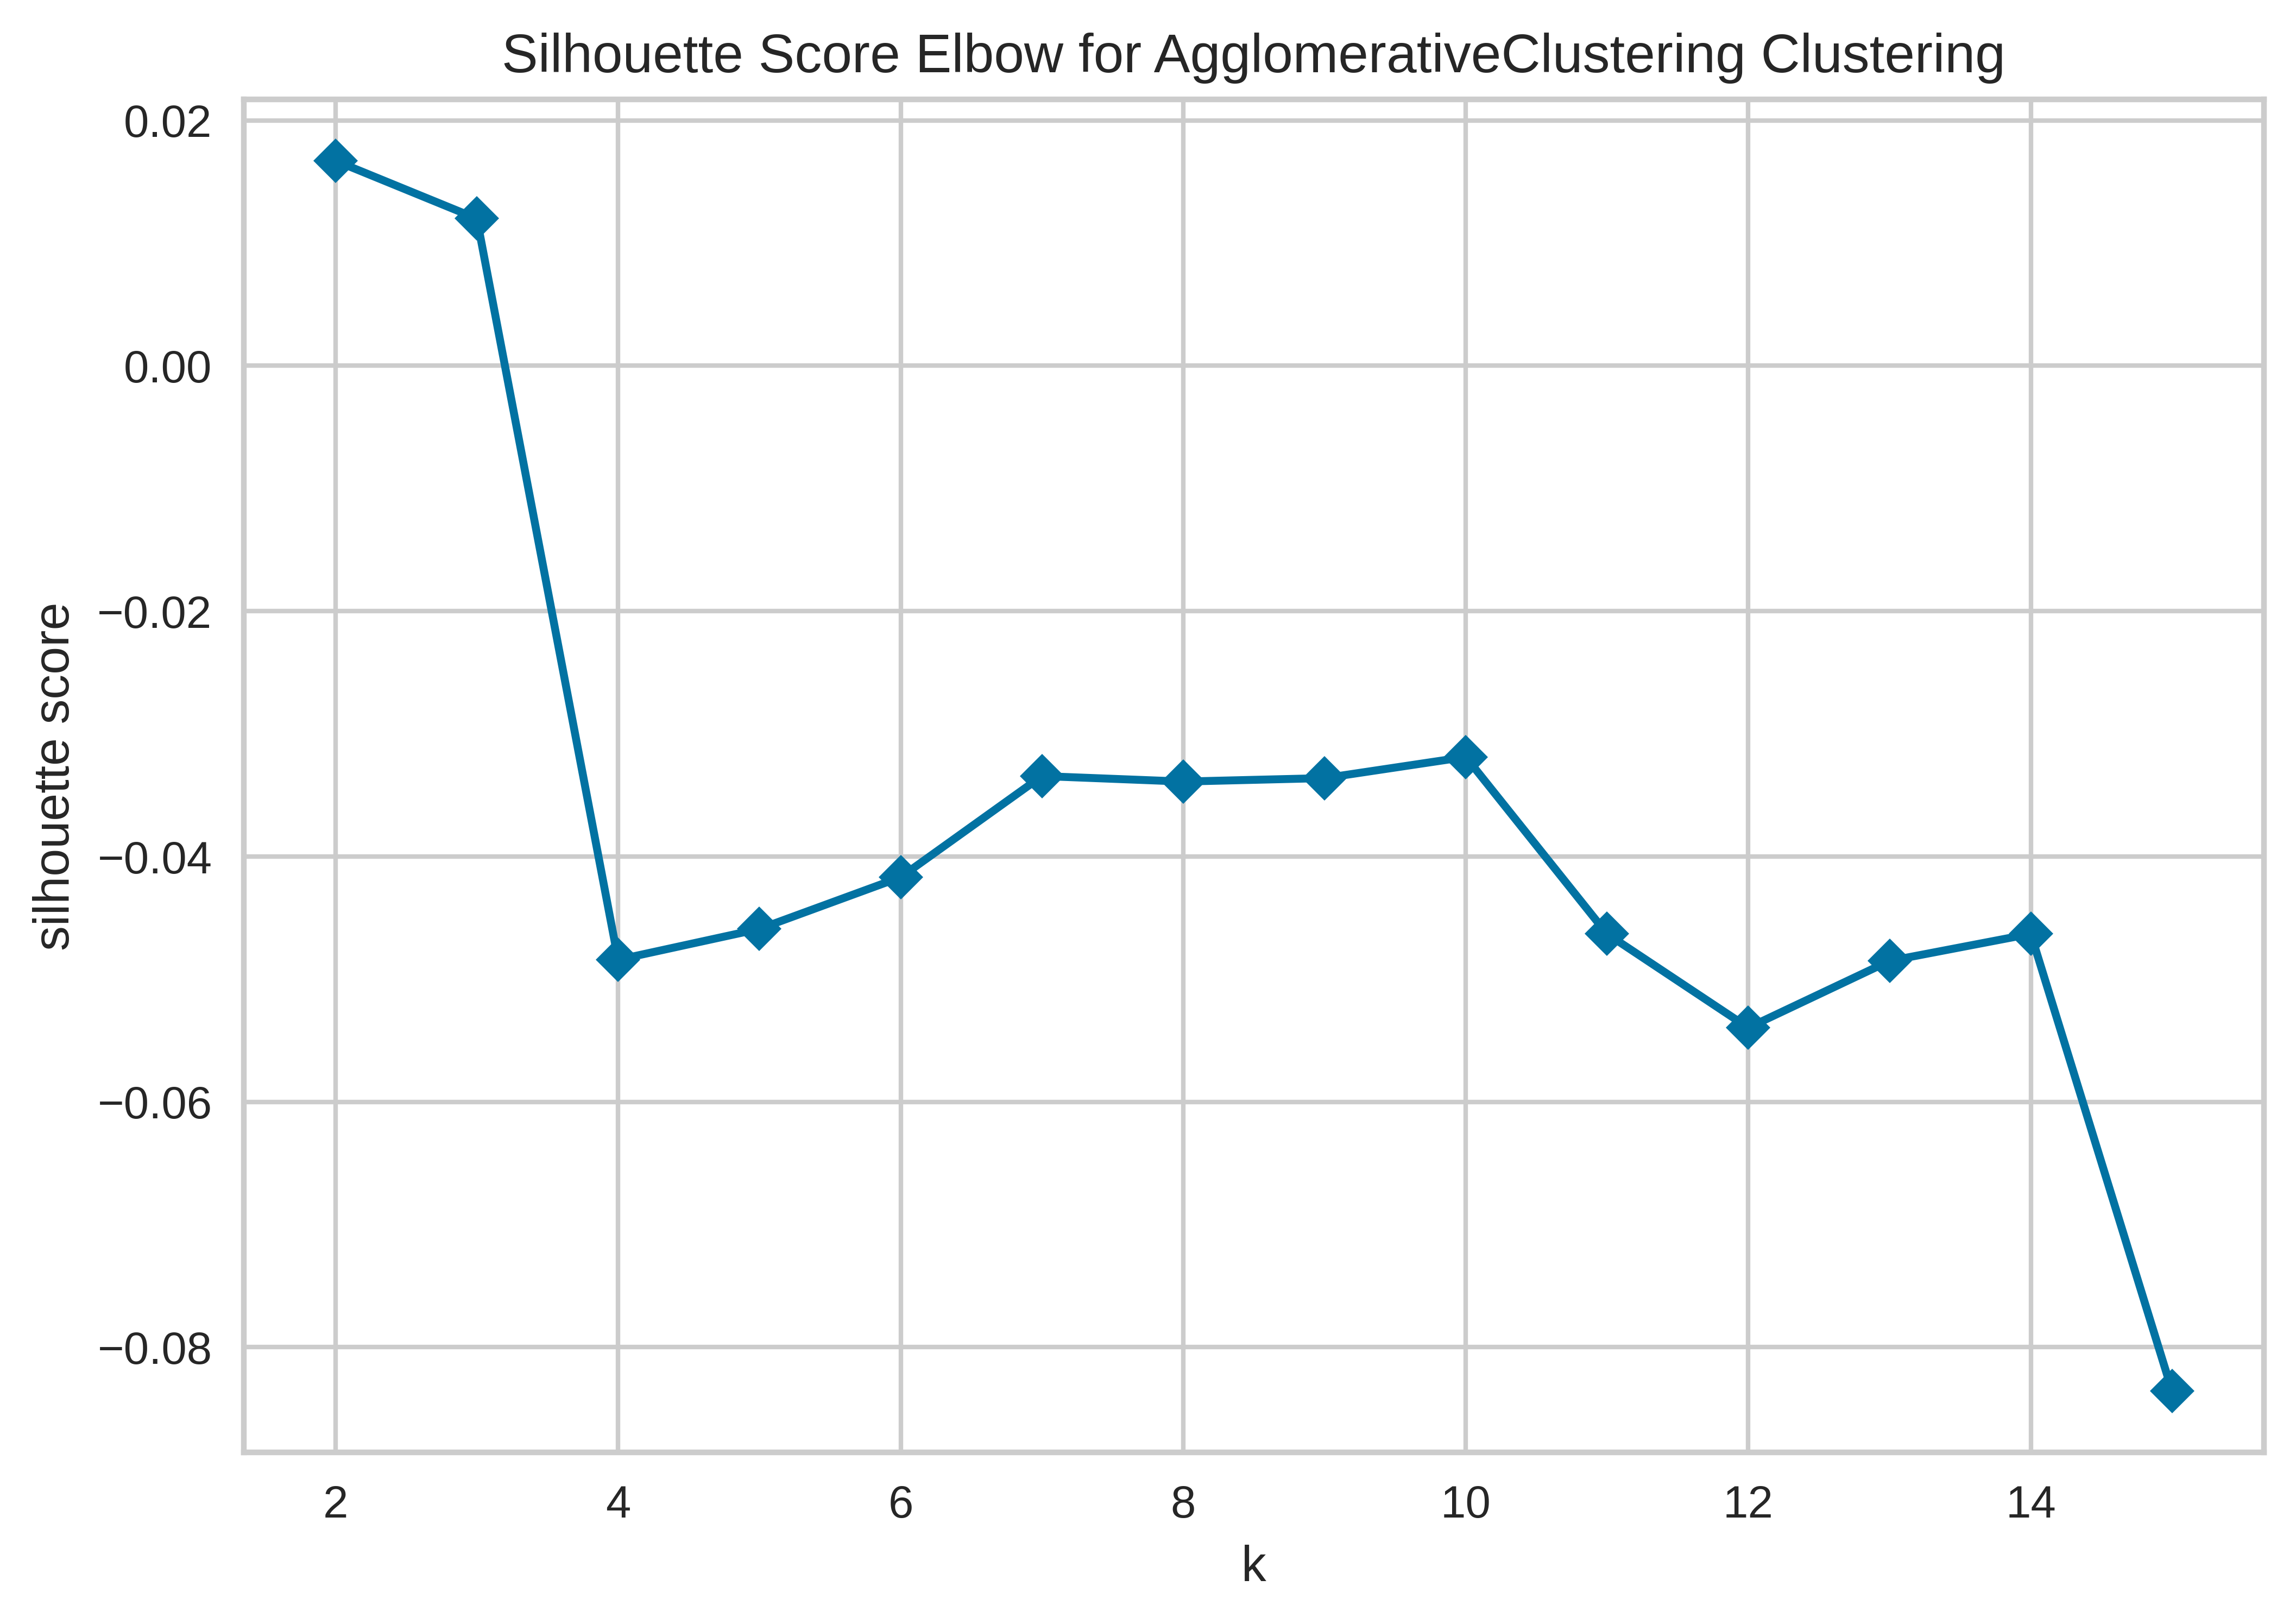

<ipython-input-17-fccb64e3fcde>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_cmap_sigs.loc[oe_targets])


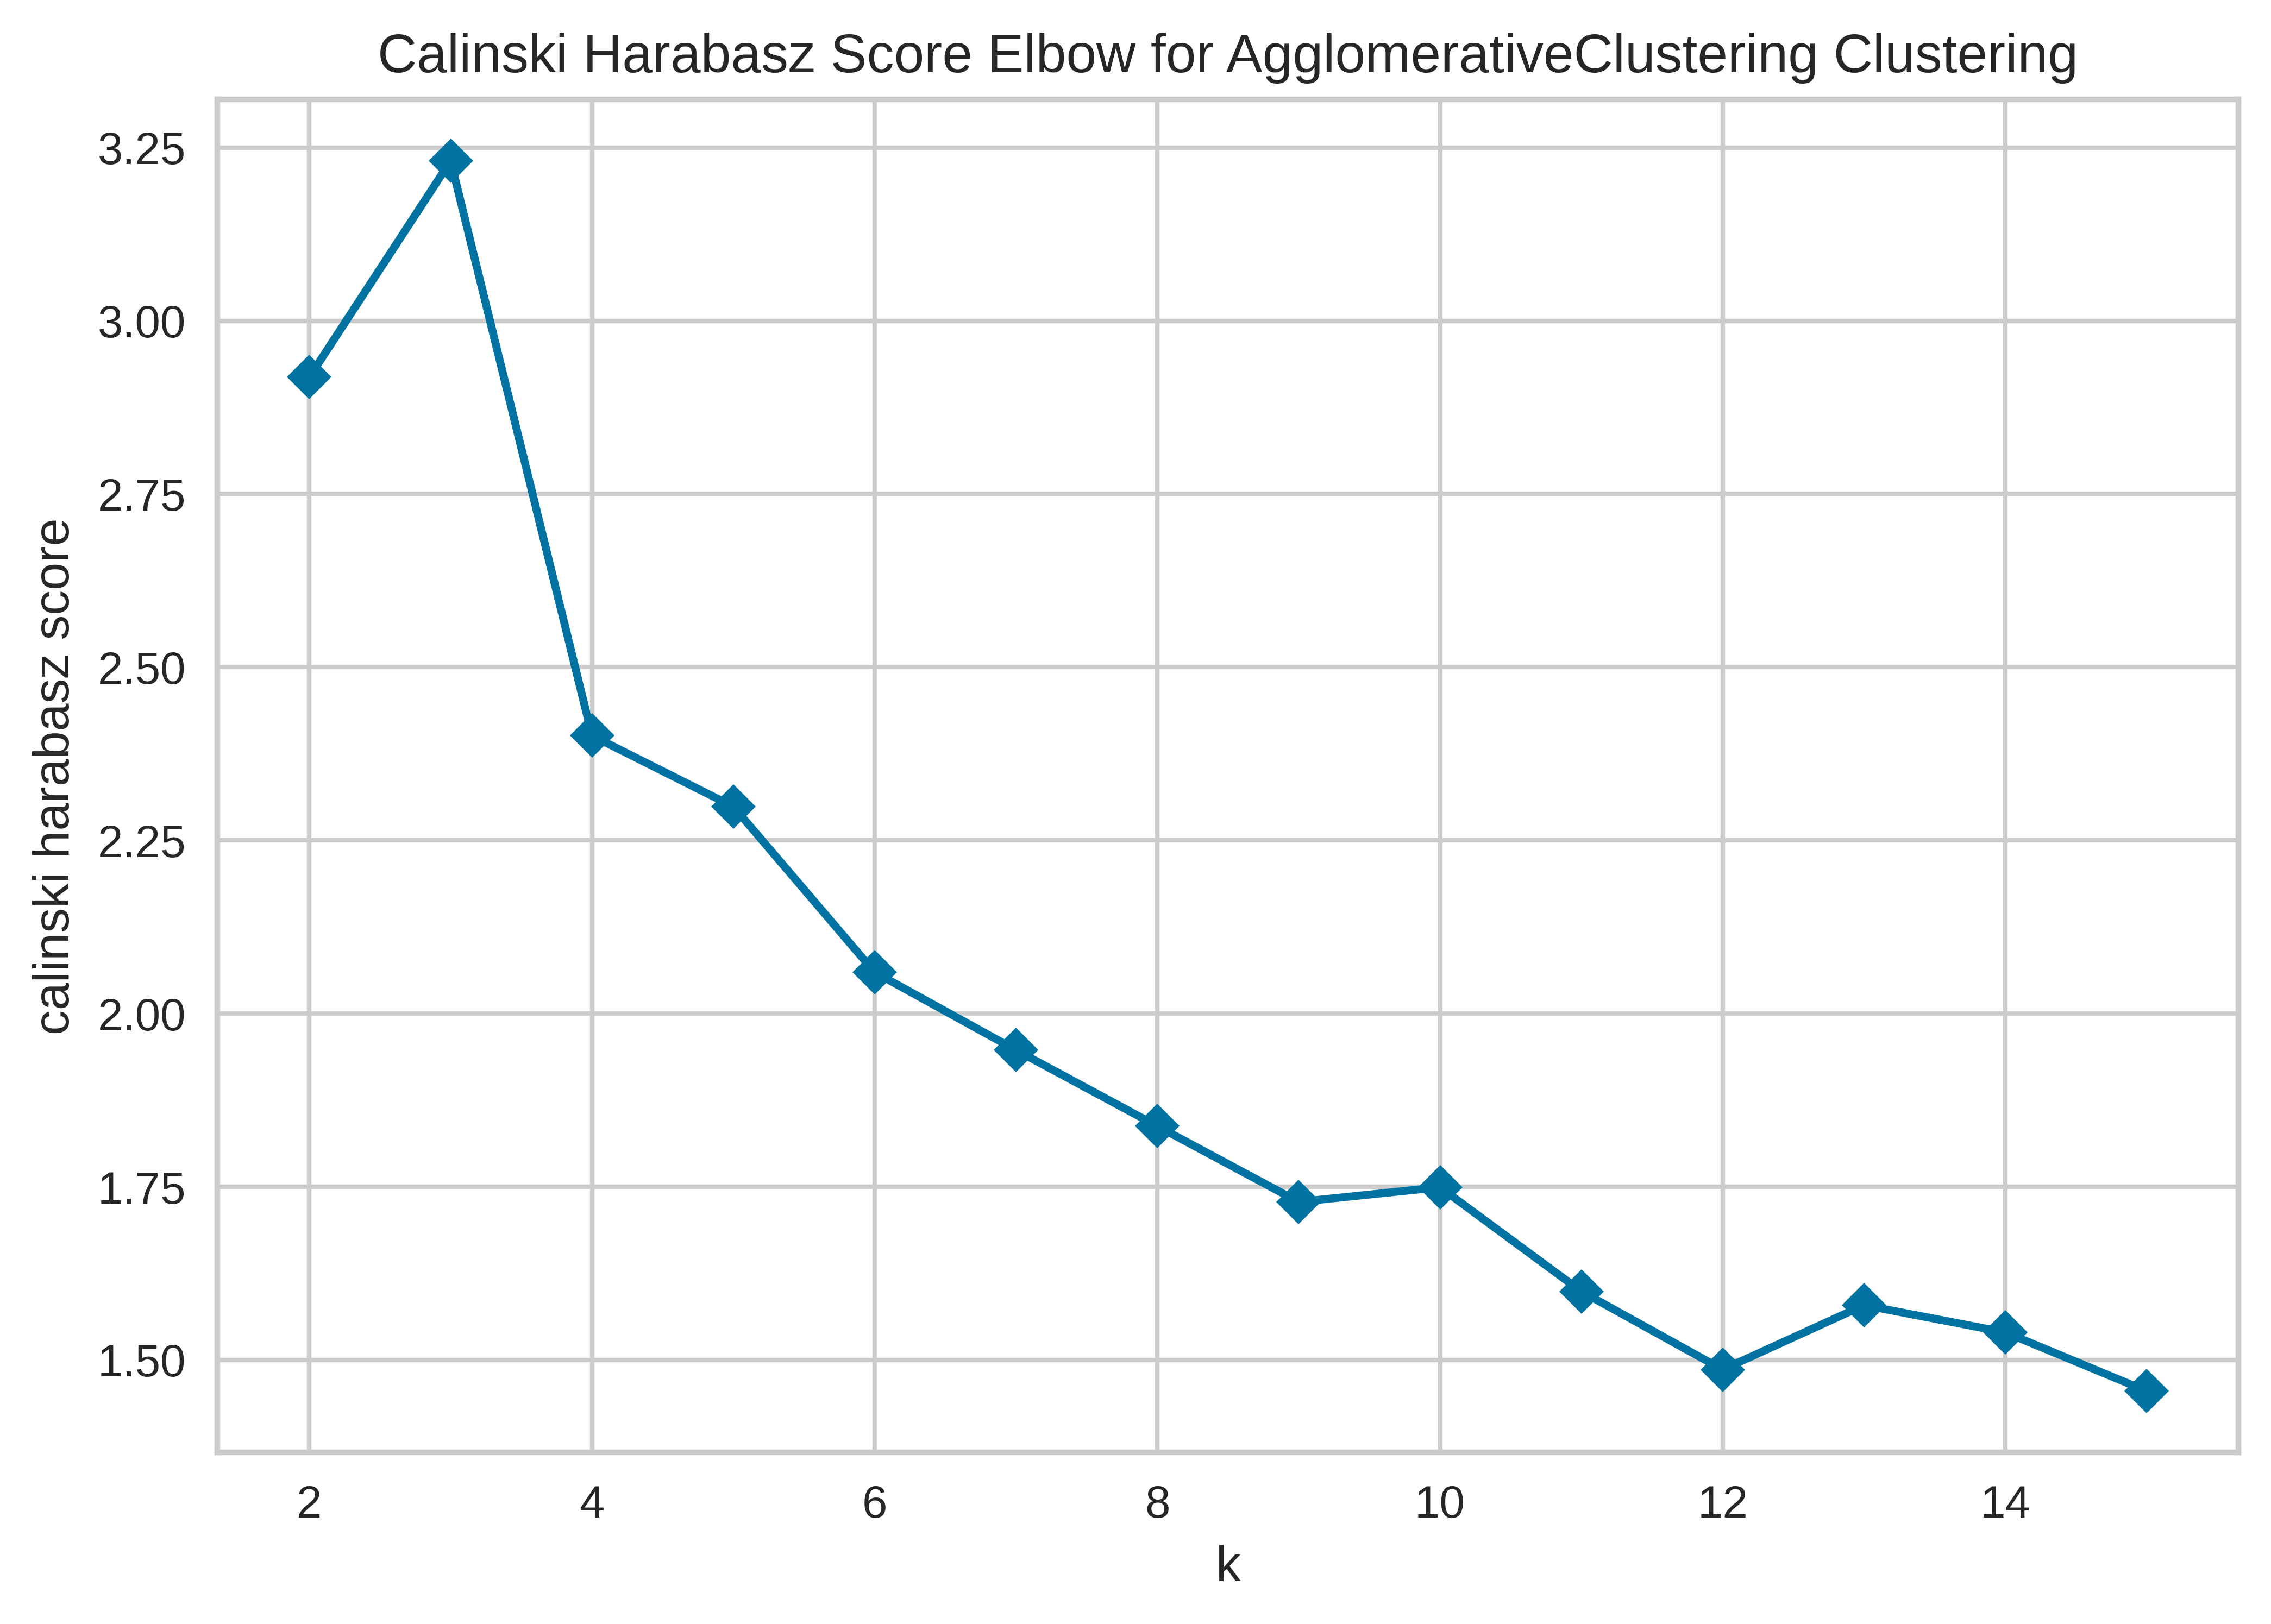

In [17]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_cmap_sigs.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_cmap_sigs.loc[oe_targets])
ax = visualizer.show()

The above plots suggest the use of 3 clusters as an optimal solution to cluster the CMAP signatures as we see the corresponding solution to maximize the Calinski-Harabasz score. However, to ensure that the number of clusters is roughly the same when comparing the corresponding solutions, we choose the solution with 10 clusters for which the Silhouette and Calinski-Harabasz score also achieve local optima.

In [18]:
model = AgglomerativeClustering(n_clusters=10, affinity="cosine", linkage="complete")
cmap_sigs_cluster_labels = model.fit_predict(mean_cmap_sigs.loc[oe_targets])
cmap_sigs_clusters = pd.DataFrame(
    cmap_sigs_cluster_labels,
    index=mean_cmap_sigs.loc[oe_targets].index,
    columns=["cluster"],
)

<ipython-input-18-759a9a610a9a>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cmap_sigs_cluster_labels = model.fit_predict(mean_cmap_sigs.loc[oe_targets])
<ipython-input-18-759a9a610a9a>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_cmap_sigs.loc[oe_targets].index,


The statistical significance of the co-clustering of the two spaces is assessed by testing if the mutual information score is higher than chance using a permutation test.

In [19]:
phy_space_cmap_sig_cc_test_results = run_cc_test(
    np.array(phy_space_clusters.loc[sorted(oe_targets), "cluster"]),
    np.array(cmap_sigs_clusters.loc[sorted(oe_targets), "cluster"]),
    random_state=1234,
    score="mi",
    b=100000,
)

100%|██████████| 100000/100000 [01:06<00:00, 1504.51it/s]


In [20]:
print(
    "MI:",
    phy_space_cmap_sig_cc_test_results["cc_score"],
    "p-value:",
    phy_space_cmap_sig_cc_test_results["pval"],
)

MI: 1.226707577281965 p-value: 0.0


As indicated above using 100,000 permutations we observe the co-clustering to be highly significant i.e. p-value < 1e-5.

---

### 3.c. Clustering of the morphological profiles

Next, we run a similar analysis using the morphological profiles by Rohban et al. (2017).

In [21]:
mean_morph_profile_dist = pd.DataFrame(
    squareform(pdist(mean_morph_profiles.loc[oe_targets])),
    index=mean_morph_profiles.loc[oe_targets].index,
    columns=mean_morph_profiles.loc[oe_targets].index,
)

linkage = hc.linkage(squareform(mean_morph_profile_dist), method="complete")

ax = sns.clustermap(
    mean_morph_profile_dist,
    figsize=[14, 12],
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="magma",
    row_colors=np.array(phy_space_colors.loc[mean_morph_profile_dist.index]),
    col_colors=np.array(phy_space_colors.loc[mean_morph_profile_dist.index]),
    dendrogram_ratio=0.1,
    cbar_pos=(0.04, 0.88, 0.03, 0.1),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_heatmap.set_ylabel("")
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
ax.ax_cbar.set_ylabel("Euclidean\ndistance", size=15, weight="bold")
ax.ax_cbar.yaxis.set_label_position("left")
plt.show()

<ipython-input-21-9a07f3a59d86>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  squareform(pdist(mean_morph_profiles.loc[oe_targets])),
<ipython-input-21-9a07f3a59d86>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_morph_profiles.loc[oe_targets].index,
<ipython-input-21-9a07f3a59d86>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  columns=mean_morph_profiles.loc[oe_targets].index,


Again, the cluster plot suggests a significant co-clustering which we will quantify now as before for the CMAP signatures.

<ipython-input-22-273ce417c17c>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_morph_profiles.loc[oe_targets])


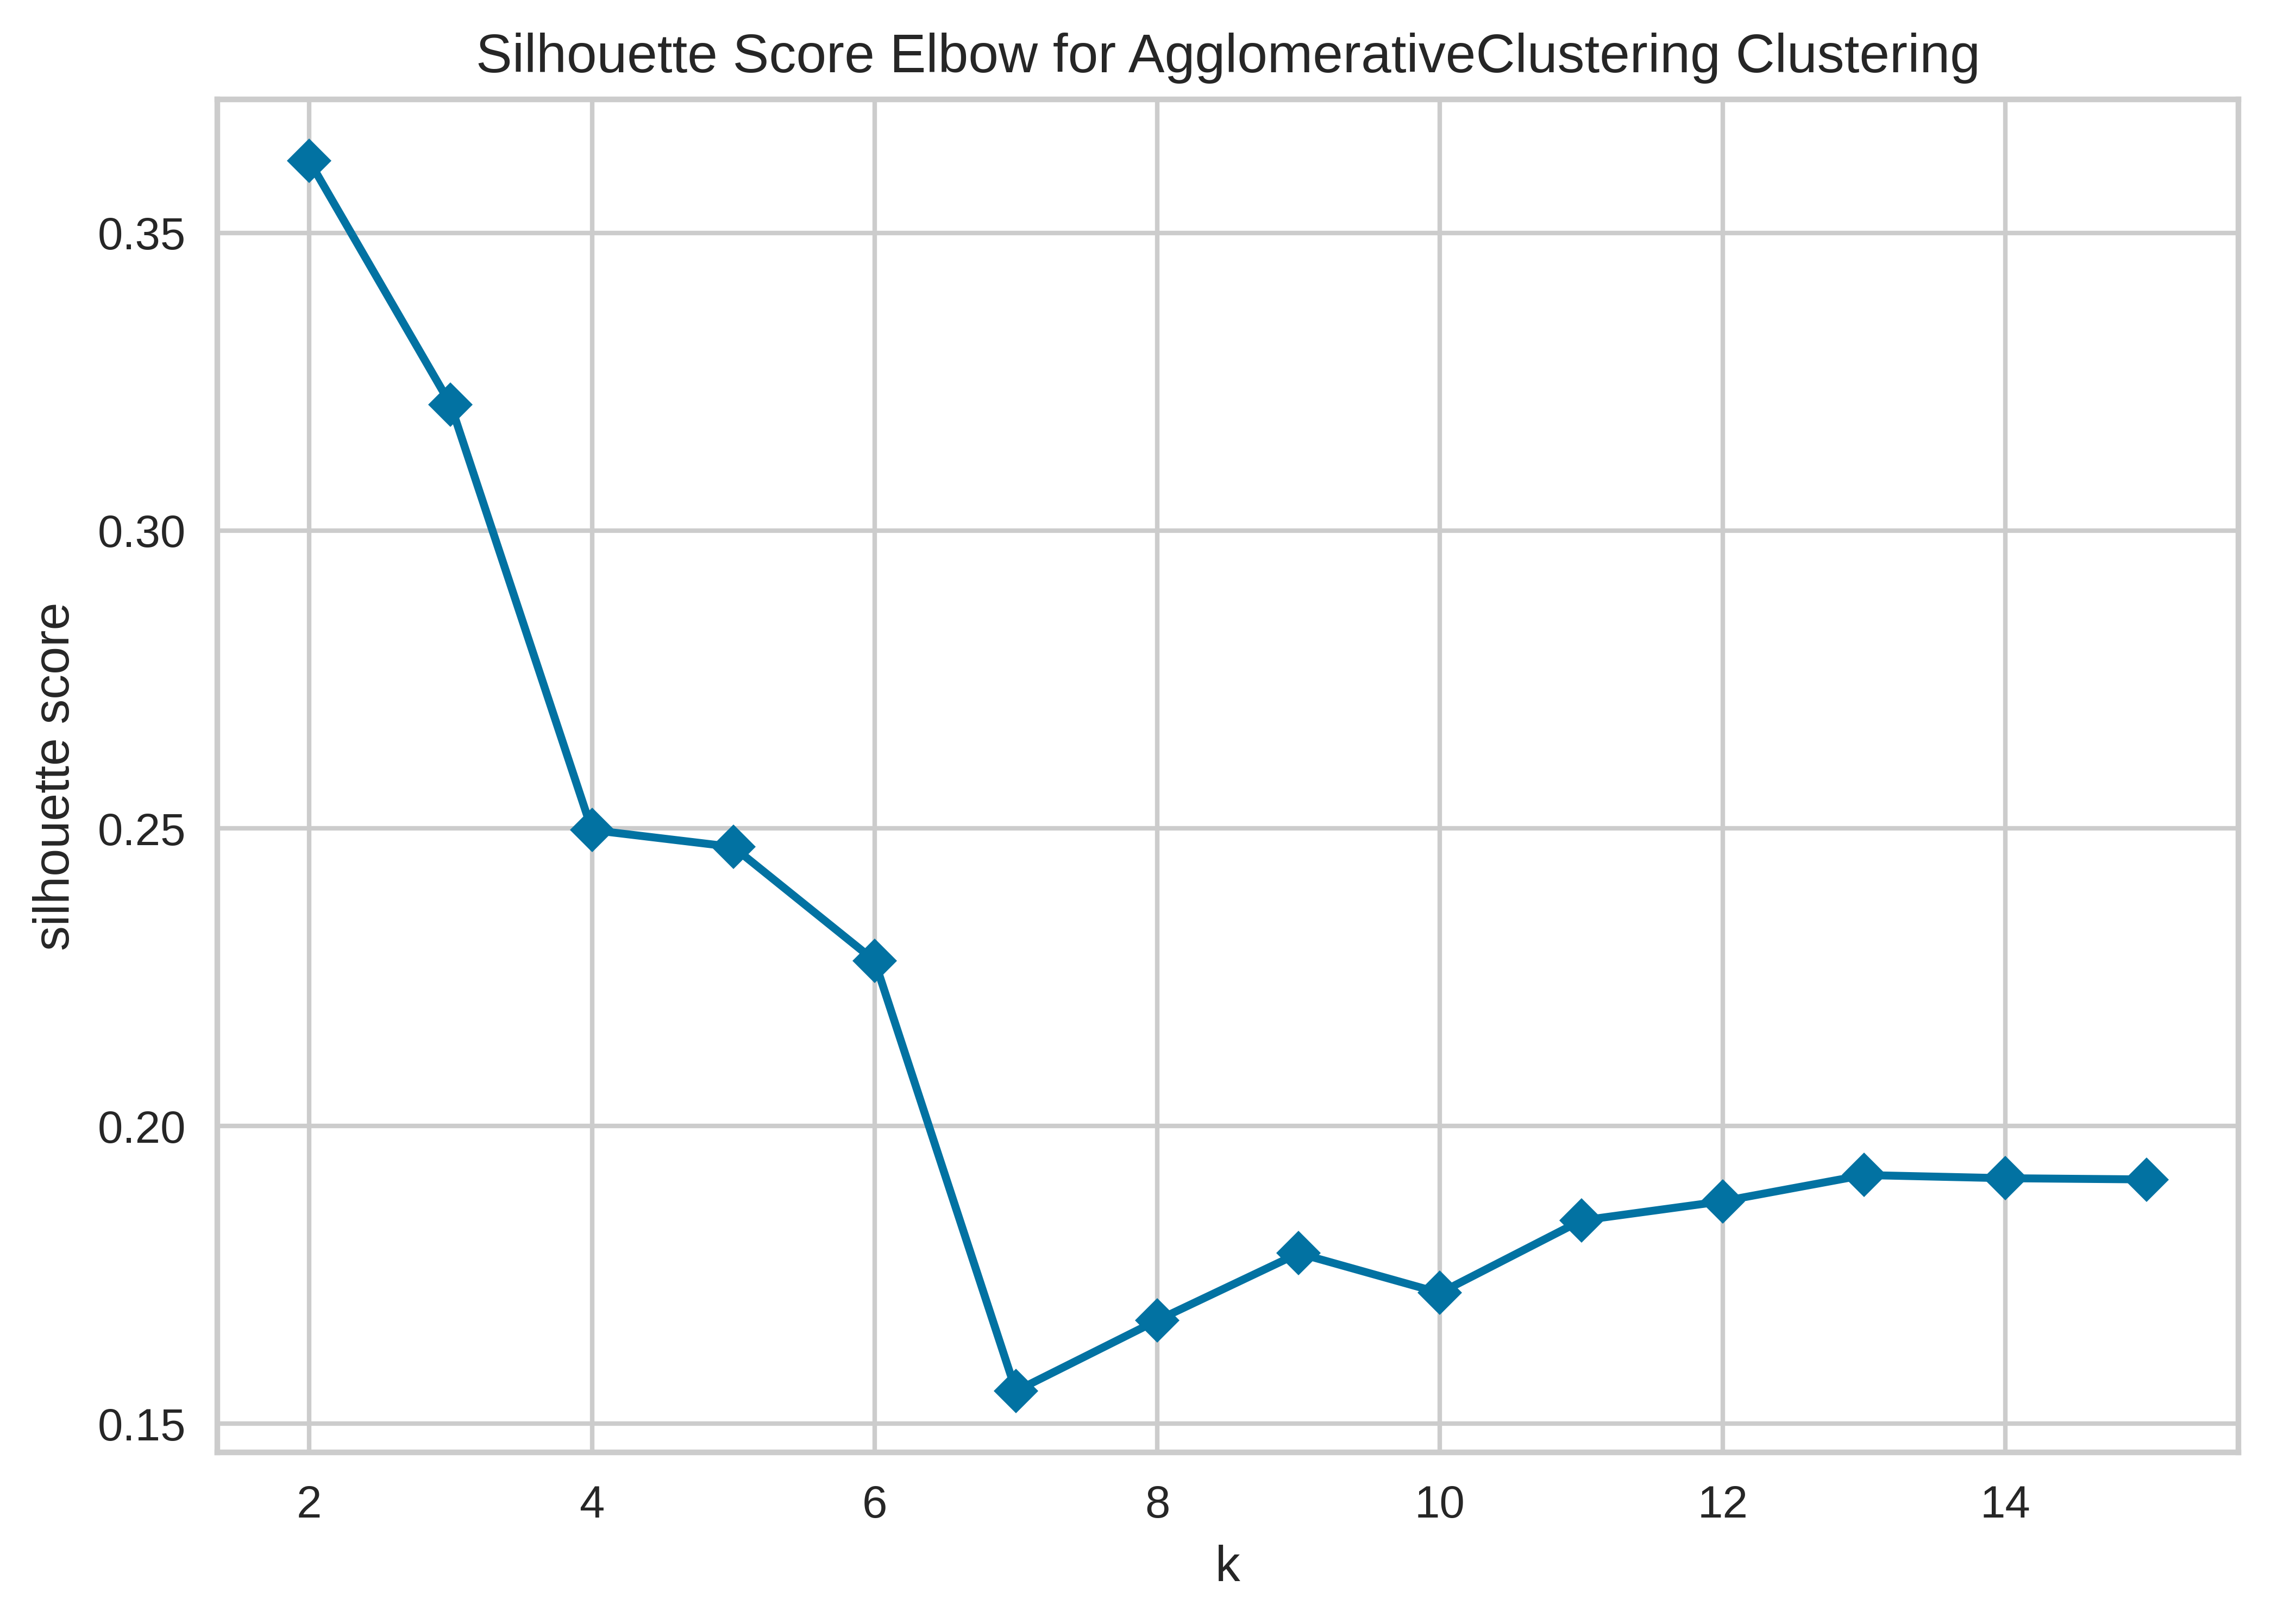

<ipython-input-22-273ce417c17c>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  visualizer.fit(mean_morph_profiles.loc[oe_targets])


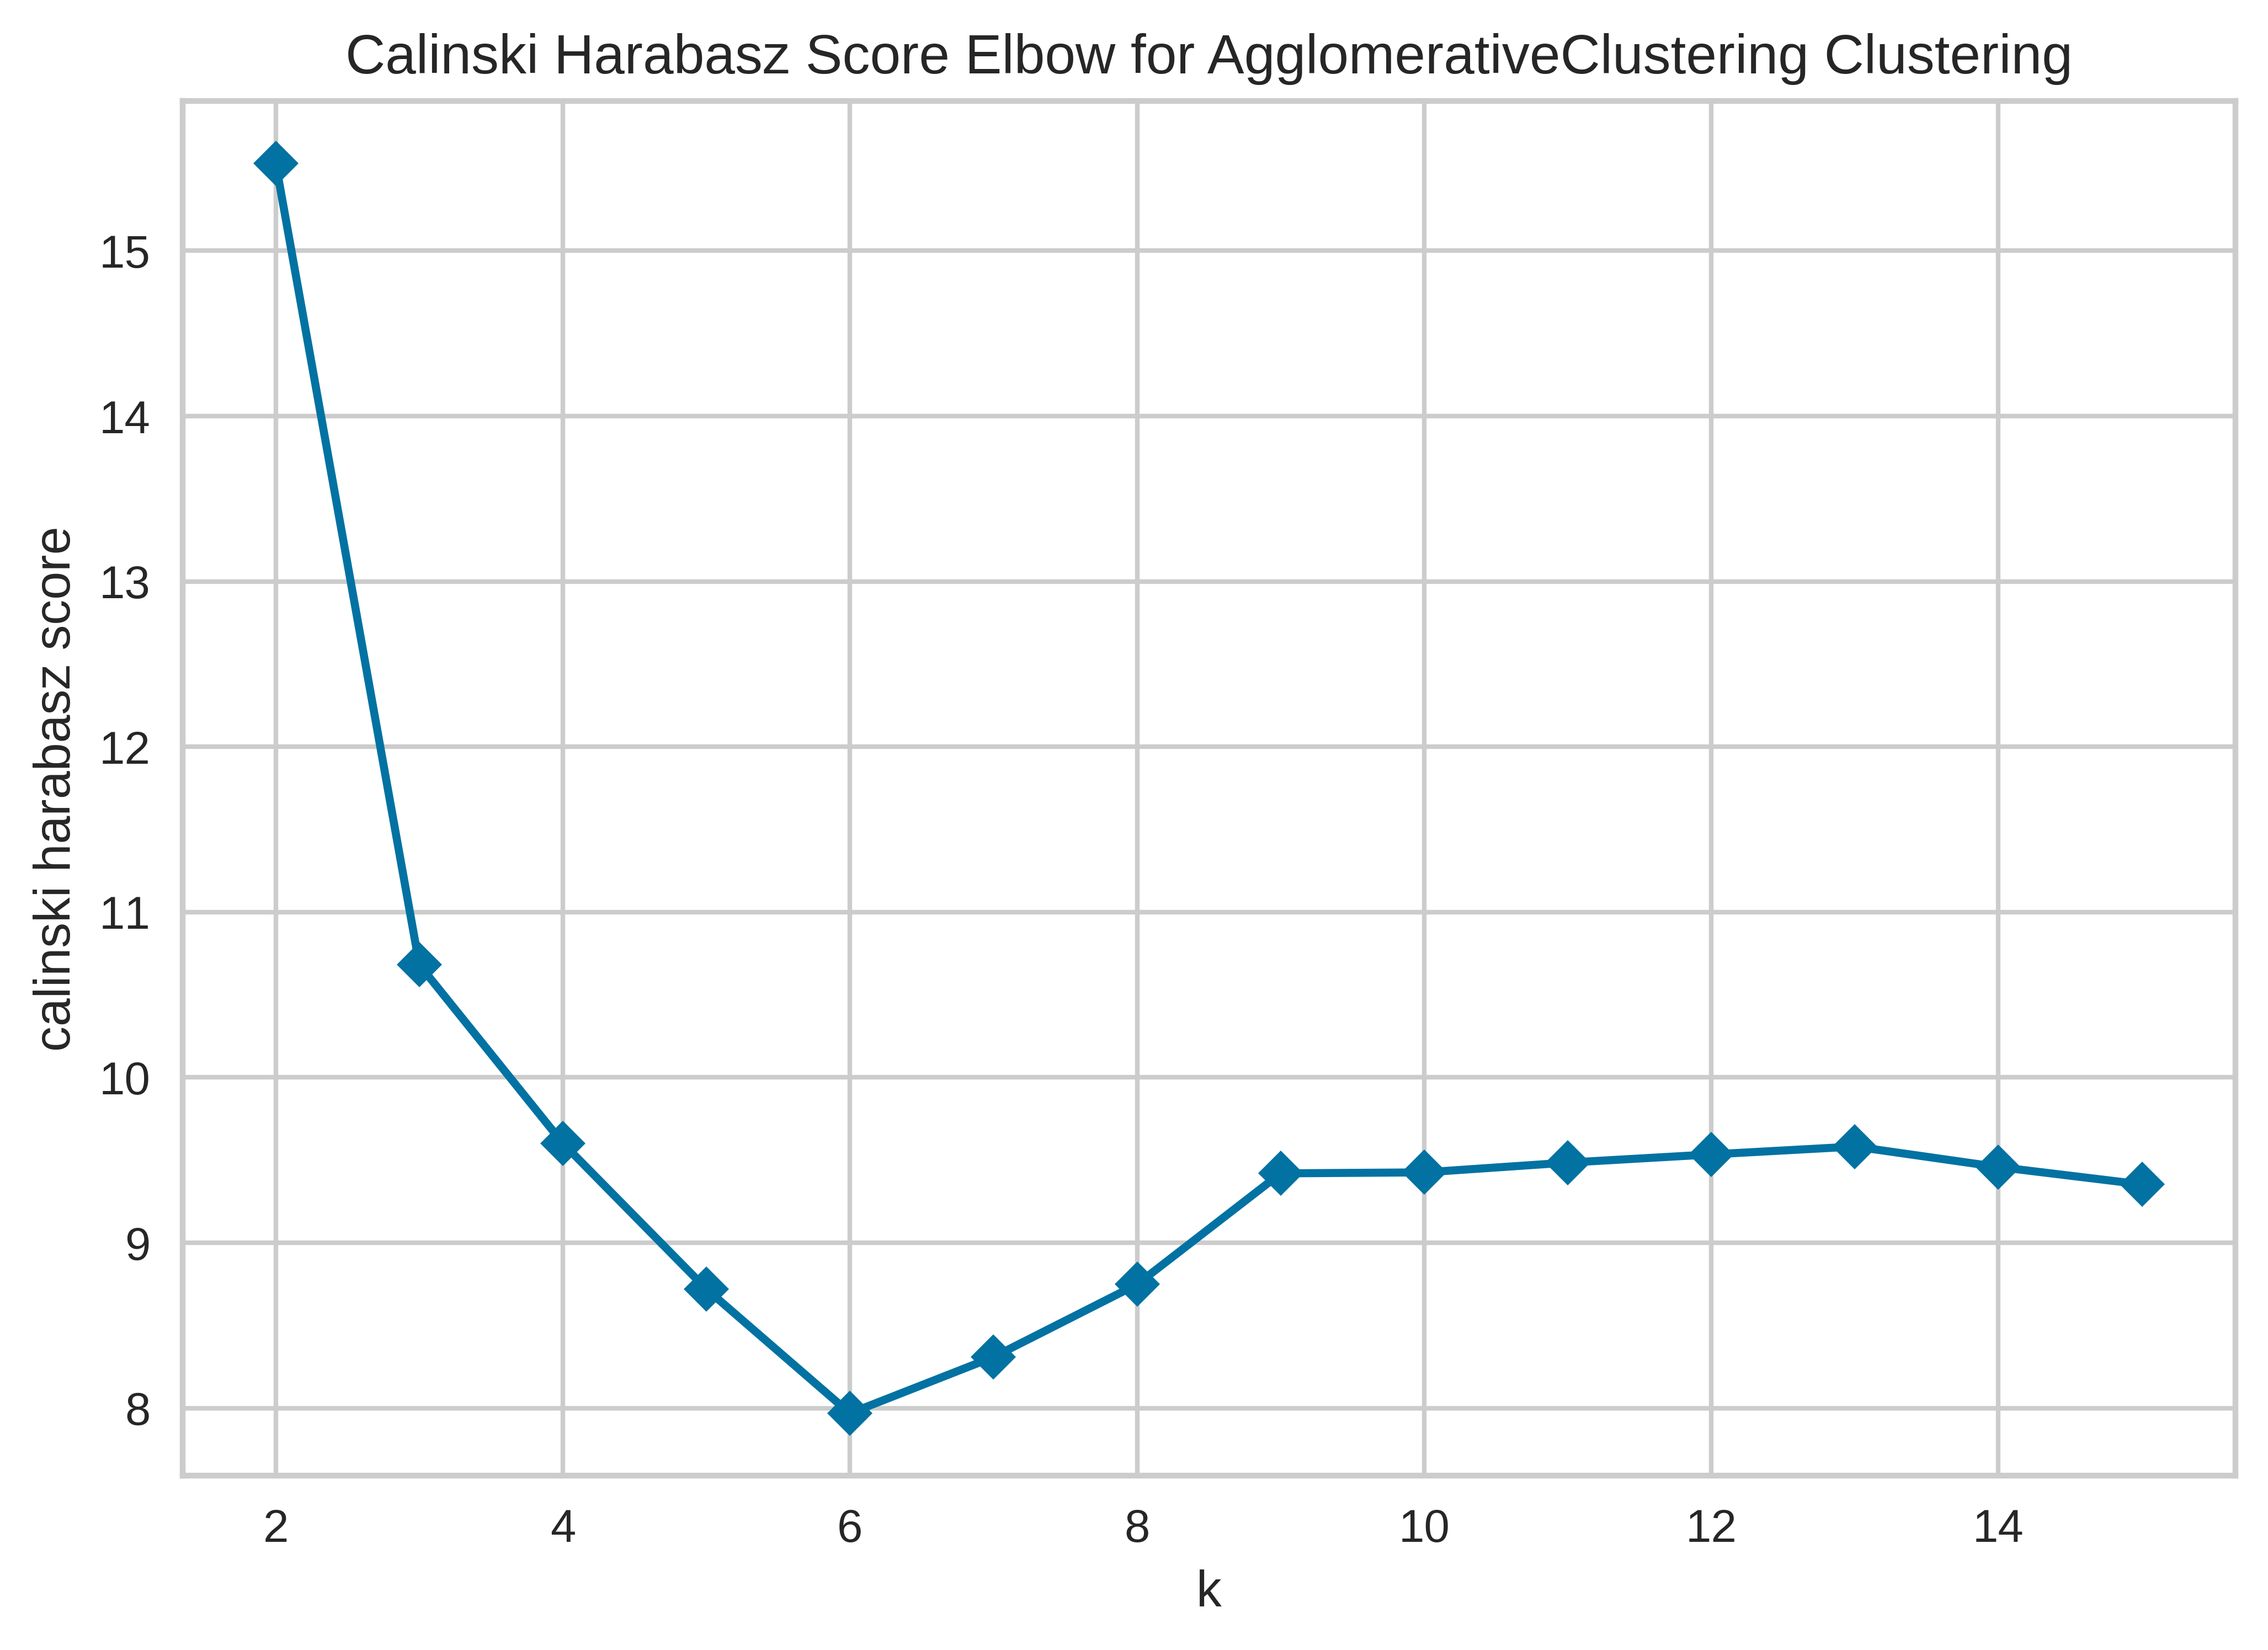

In [22]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_morph_profiles.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_morph_profiles.loc[oe_targets])
ax = visualizer.show()

We find a maxima close to the number of clusters chosen for the physical space that divides the target gene set into 7 clusters based on the morphological embeddings.

In [23]:
model = AgglomerativeClustering(n_clusters=9, affinity="euclidean", linkage="complete")
profile_cluster_labels = model.fit_predict(mean_morph_profiles.loc[oe_targets])
profile_clusters = pd.DataFrame(
    profile_cluster_labels,
    index=mean_morph_profiles.loc[oe_targets].index,
    columns=["cluster"],
)

<ipython-input-23-12ccc96ba0c8>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  profile_cluster_labels = model.fit_predict(mean_morph_profiles.loc[oe_targets])
<ipython-input-23-12ccc96ba0c8>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index=mean_morph_profiles.loc[oe_targets].index,


In [24]:
phy_space_morph_profile_cc_test_results = run_cc_test(
    np.array(phy_space_clusters.loc[sorted(oe_targets), "cluster"]),
    np.array(profile_clusters.loc[sorted(oe_targets), "cluster"]),
    random_state=1234,
    score="mi",
    b=100000,
)

100%|██████████| 100000/100000 [01:06<00:00, 1494.69it/s]


In [25]:
print(
    "MI:",
    phy_space_morph_profile_cc_test_results["cc_score"],
    "p-value:",
    phy_space_morph_profile_cc_test_results["pval"],
)

MI: 1.240712766475025 p-value: 0.0


As before we observe the co-clustering measured by the mutual information to be highly signficant p value < 1e-5) as indicated by the applied permutation test.

---

### 3.3. Discussion

The observed co-clustering of the phyiscal and functional spaces has three major implications. First, it validates our inferred physical space embeddings due to the similarity of the structure of those to the morphological profiles by Rohban et al. (2017) validated in a preceding study. Second, it indicates that the proximity of gene targets in the physical space partially captures functional relationships between individual genes. Third, the transcriptional profiles upon overexpression estimated by the CMAP signatures are a dictated by the regulatory links in the cell and the pathways in the cell triggering specific signaling cascades upon overexpression. Thus, the proximity in the functional space should partially translate to regulatory proximity of genes. 

We note that the inferred CMAP signatures as interventional data provide a power supplement to purely observational gene expression data for the inference of the regulatory space. It has previously been shown that activity of individual pathways and the role of the genes in those highly depends on the signal transduced to those. Thus, the use of the interventional gene expression data is important to identify the specific signaling cascades used by the cells in the different overexpression conditions. In addition to the CMAP signatures we will provide higher level information for the inference stemming from clustering the signature space.

---

## 4. Data export

As described above we aim to use the cluster structure as well as the "raw" CMAP signatures to guide the inference of the regulatory space to better capture the specific signaling cascade activated in the cells upon overexpression which are weakly described by purely observational data.

To this end, we will export the corresponding gene signature data set, the L1000 gene set information as well as the clusters identified clusters of the physical and CMAP signature space.

In [29]:
# os.makedirs("../../../../data/experiments/rohban/other", exist_ok=True)
# cmap_sigs_clusters.to_csv(
#     "../../../../data/experiments/rohban/other/cmap_sig_clusters.csv"
# )
# phy_space_clusters.to_csv(
#     "../../../../data/experiments/rohban/other/mean_physical_clusters.csv"
# )